In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tangent_boundaries as tb
from math import pi
from scipy.sparse import csr_matrix, csc_matrix, linalg as sla
from functools import partial

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

## Build a function that generates some other shape

In [5]:
def generate_ellipse(r1,r2,npoints=1000):
    'Generates the set of points in the grid closest to an elipse with radii r1 and r2 and the angle of the normal vector.'
    theta = np.linspace(0, 2*np.pi, npoints)
    x = r1*np.cos(theta)
    y = r2*np.sin(theta)
    angles = np.where(np.abs(theta-pi)<=pi/2, np.arctan((r1/r2)*np.tan(theta))+pi, np.arctan((r1/r2)*np.tan(theta)))
    z = np.exp(1j*angles)

    boundary_points, indices = np.unique(np.round(np.stack((x, y))), axis = 1, return_inverse=True)

    # Calculate the sum of elements in z that correspond to the same value in mask
    sums_real = np.bincount(indices, weights=z.real)
    sums_imag = np.bincount(indices, weights=z.imag)
    
    # Calculate the count of elements in b that correspond to the same value in mask
    counts = np.bincount(indices)
    
    # Calculate the average of elements in b that correspond to the same value in mask
    normal_angles = np.angle((sums_real + 1j*sums_imag)/counts)
    

    
    return boundary_points, normal_angles

/tmp/ipykernel_17408/1790092913.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_17408/1790092913.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


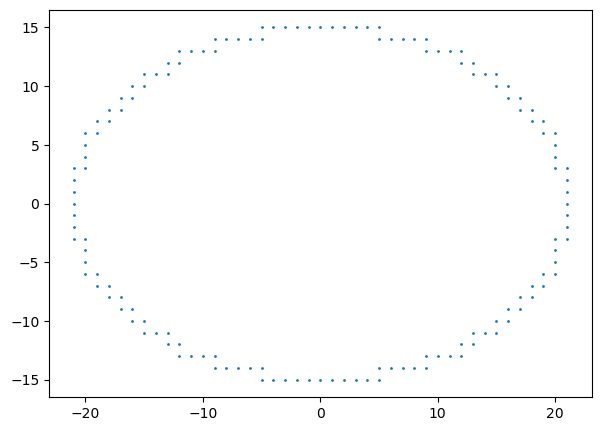

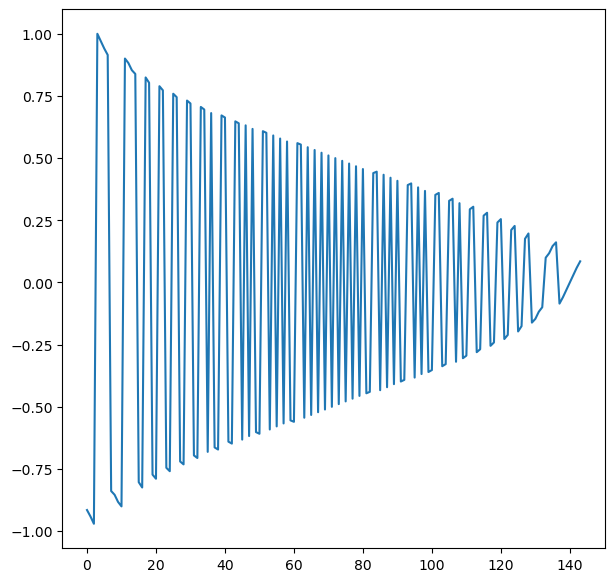

In [4]:
boundary_points, normal_angles = generate_ellipse(21,15, npoints =100000 )
NNpoints = len(boundary_points[0])
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.scatter(boundary_points[0,:NNpoints],boundary_points[1,:NNpoints], s = 1)

ax.set_aspect('equal')
fig.show()

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.plot(normal_angles[:NNpoints]/pi)

fig.show()

### Now we have to incorporate this into the function that builds the Hamiltonian.

In [8]:
#Testing

Nx = 43
Ny = 35
def get_index(x,y,s):
    '''Returns the index of the orbital in x,y with spin s'''
    return int(Nx*Ny*s + Nx*y + x)

edge_points, normal_angles = generate_ellipse(r1 = Nx//2, r2 = Ny//2)
edge_points = edge_points + np.array([[Nx//2]*(len(edge_points[1])),[Ny//2]*(len(edge_points[1]))])

indices_to_delete = []

#Delete edges
for point in zip(edge_points[0], edge_points[1]):
    #book index to delete
    indices_to_delete.append(get_index(point[0],point[1],1))


#Delete outside
amount_out = 0
X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
for x,y in zip(X.ravel(),Y.ravel()):
    if ((x-Nx//2)/(Nx//2))**2+((y-Ny//2)/(Ny//2))**2 > 1 and  get_index(x,y,1) not in indices_to_delete:
        indices_to_delete.append(get_index(x,y,0))
        indices_to_delete.append(get_index(x,y,1))
        amount_out += 1

In [9]:
inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)

inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)

/tmp/ipykernel_10843/3942523850.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


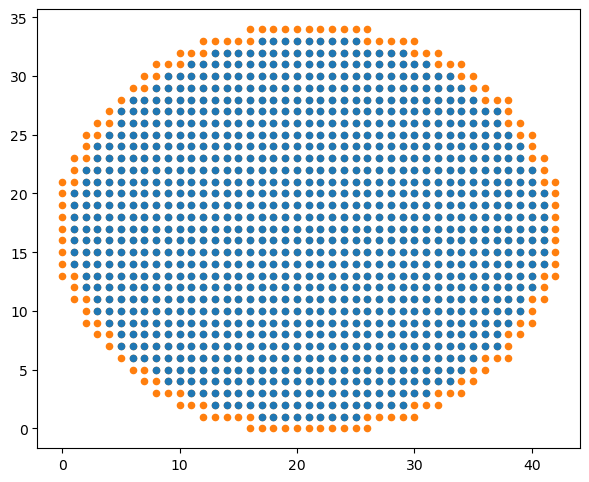

In [10]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.scatter(inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:], s = 20)
ax.scatter(inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out], s = 20,zorder=-1)

ax.set_aspect('equal')
fig.show()

## It sems that this approach for obtaining indices to delete works

In [2]:
def operators_ellipse(parameters, plot_potential = False, plot_mass = False, plot_mag_field = False,return_shape = False):
    '''Returns operators Phi, H and P for a square 
    geometry boundary condition given by a magnetization that rotates parallel to the edge.'''
    
    Nx = parameters['Nx']     # Number of unit cells in x direction (should be odd)
    Ny = parameters['Ny']     # Number of unit cells in y direction (should be odd)
    kx = 0    # open system
    ky = 0    # open system
    
    #Generate Peierls phases
    #np.random.seed(0)
    if parameters['B1'] == 0:
        a_e = np.zeros((Ny,Nx))
        a_n = np.zeros((Ny,Nx))
    else:
        fluxes = make_fluxes(parameters, plot = plot_mag_field)
        a_e, a_n = vector_potential(parameters,fluxes)
        
    parameters['a_e'] = a_e
    parameters['a_n'] = a_n
    
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []    

    for i in range(Nx*Ny):
        y = i//Nx
        x = i%Nx
        
        #Peierls phases
        p_e = np.exp(1j*(a_e[y,x]))
        p_n = np.exp(1j*(a_n[y,x]))
        
        #Standard translations
        trs_e = np.exp(-(1j*kx*Nx)*((x+1)//Nx))
        trs_n = np.exp(-(1j*ky*Ny)*((y+1)//Ny))
        
        #Total phases
        phase_e = p_e*trs_e
        phase_n = p_n*trs_n
        
        row_Tx += [i]
        col_Tx += [((x+1)%Nx) + y*Nx]
        data_Tx += [phase_e*(1-(x//(Nx-1)))] ################## Open boundaries in x direction
        
        row_Ty += [i]
        col_Ty += [x + ((y+1)%Ny)*Nx]
        data_Ty += [phase_n*(1-(y//(Ny-1)))] ################## Open boundaries in y direction
        
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2

    potential_array = make_potential(parameters, plot = plot_potential).flatten()    
    pot = scipy.sparse.spdiags(potential_array, 0, Nx*Ny, Nx*Ny, format = "csc")
    V = scipy.sparse.kron(csc_matrix(sigma_0), pot, format = "csc")    
    
    mass_array = make_mass(parameters, plot = plot_mass).flatten()    
    mass = scipy.sparse.spdiags(mass_array, 0, Nx*Ny, Nx*Ny, format = "csc")
    M = scipy.sparse.kron(csc_matrix(sigma_z), mass, format = "csc")
    
    
    H_0 = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    H = H_0 + Phi.H@V@Phi + Phi.H@M@Phi

    
    # Unitary transformation on the edges. Let us build a rotation matrix that acts on a single site.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a (theta,phi) orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    def get_index(x,y,s):
        '''Returns the index of the orbital in x,y with spin s'''
        return int(Nx*Ny*s + Nx*y + x)

    edge_points, normal_angles = generate_elipse(r1 = Nx//2, r2 = Ny//2)
    edge_points = edge_points + np.array([[Nx//2]*(len(edge_points[1])),[Ny//2]*(len(edge_points[1]))])
    # the parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
    
    theta = parameters['theta']
    indices_to_delete = []
    
    for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):
        
        #rotate
        rotation = spin_rotation([point[0],point[1]], theta, point[2]) 
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
        
        #book index to delete
        indices_to_delete.append(get_index(point[0],point[1],1))

    #Now we also have to delete the outer part
    amount_out = 0
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    for x,y in zip(X.ravel(),Y.ravel()):
        if ((x-Nx//2)/(Nx//2))**2+((y-Ny//2)/(Ny//2))**2 > 1 and  get_index(x,y,1) not in indices_to_delete:
            indices_to_delete.append(get_index(x,y,0))
            indices_to_delete.append(get_index(x,y,1))
            amount_out += 1

            
    # Transforming the sparse matrix into dense to delete spins (could I avoid this?)
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
   
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi

    if return_shape:
        inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)
        inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
        inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
        inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)
    
        return Phi, H, P, indices_to_delete, (inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:]), (inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out])
    else:
        return Phi, H, P, indices_to_delete

In [524]:
def generate_stadium(r,L,npoints=10001):
    'Generates the set of points in the grid closest to an elipse with radii r1 and r2 and the angle of the normal vector.'
    theta = np.linspace(0, 2*pi, npoints, endpoint = False)
    sign_theta = 2*np.heaviside(theta-pi,0)-1
    cos_theta_plus = (np.cos(theta))**2   *    (-L/r*np.tan(theta)  + np.sqrt( np.ones(npoints) - ((np.tan(theta))**2*L**2/r**2-1)*(np.tan(theta))**2 ) )
    cos_theta_minus = (np.cos(theta))**2   *    (-L/r*np.tan(theta)  - np.sqrt( np.ones(npoints) - ((np.tan(theta))**2*L**2/r**2-1)*(np.tan(theta))**2 ) )
    
    cos_theta_prime = np.where(sign_theta*np.cos(theta)<=0, cos_theta_plus, cos_theta_minus)
    
    plt.plot(theta/pi,cos_theta_plus)
    plt.plot(theta/pi,cos_theta_minus)
    plt.axvline(np.arctan(r/L)/pi)
    plt.axvline(1-np.arctan(r/L)/pi)
    plt.axhline(1)
    plt.axhline(0)
    plt.axhline(-1)
    plt.axvline(2-np.arctan(r/L)/pi)
    plt.axvline(1)
    plt.axvline(1+np.arctan(r/L)/pi)
    
    x = np.zeros(npoints)
    y = np.zeros(npoints)
    angles = np.where(theta<=pi, np.arccos(cos_theta_prime),-np.arccos(-cos_theta_prime))
    

    x = np.where(np.abs(theta)<=np.arctan(r/L),L+r*cos_theta_prime,x)
    x = np.where(np.abs(theta-pi/2)<=np.arctan(L/r),r/np.tan(theta),x)
    x = np.where(np.abs(theta-pi)<=np.arctan(r/L),-L-sign_theta*r*cos_theta_prime,x)
    x = np.where(np.abs(theta-3*pi/2)<=np.arctan(L/r),-r/np.tan(theta),x)
    x = np.where(np.abs(theta-2*pi)<=np.arctan(r/L),L-r*cos_theta_prime,x)
    
    y = np.where(np.abs(theta)<=np.arctan(r/L),r*(np.sqrt(1-cos_theta_prime**2)),y)
    y = np.where(np.abs(theta-pi/2)<=np.arctan(L/r),r*np.ones(npoints),y)
    y = np.where(np.abs(theta-pi)<=np.arctan(r/L),-sign_theta*r*(np.sqrt(1-cos_theta_prime**2)),y)
    y = np.where(np.abs(theta-3*pi/2)<=np.arctan(L/r),-r*np.ones(npoints),y)
    y = np.where(np.abs(theta-2*pi)<=np.arctan(r/L),-r*(np.sqrt(1-cos_theta_prime**2)),y)
    
    
    angles = np.where(np.abs(theta-pi/2)<np.arctan(L/r),pi/2*np.ones(npoints),angles)
    angles = np.where(np.abs(theta-3*pi/2)<np.arctan(L/r),-pi/2*np.ones(npoints),angles)

    
    z = np.exp(1j*angles)


    boundary_points, indices = np.unique(np.round(np.stack((x, y))), axis = 1, return_inverse=True)

    # Calculate the sum of elements in z that correspond to the same value in mask
    sums_real = np.bincount(indices, weights=z.real)
    sums_imag = np.bincount(indices, weights=z.imag)
    
    # Calculate the count of elements in b that correspond to the same value in mask
    counts = np.bincount(indices)
    
    # Calculate the average of elements in b that correspond to the same value in mask
    normal_angles = np.angle((sums_real + 1j*sums_imag)/counts)
    
    
    return boundary_points, normal_angles

/tmp/ipykernel_11835/593593869.py:5: RuntimeWarning: invalid value encountered in sqrt
  cos_theta_plus = (np.cos(theta))**2   *    (-L/r*np.tan(theta)  + np.sqrt( np.ones(npoints) - ((np.tan(theta))**2*L**2/r**2-1)*(np.tan(theta))**2 ) )
/tmp/ipykernel_11835/593593869.py:6: RuntimeWarning: invalid value encountered in sqrt
  cos_theta_minus = (np.cos(theta))**2   *    (-L/r*np.tan(theta)  - np.sqrt( np.ones(npoints) - ((np.tan(theta))**2*L**2/r**2-1)*(np.tan(theta))**2 ) )
/tmp/ipykernel_11835/593593869.py:27: RuntimeWarning: divide by zero encountered in divide
  x = np.where(np.abs(theta-pi/2)<=np.arctan(L/r),r/np.tan(theta),x)
/tmp/ipykernel_11835/593593869.py:29: RuntimeWarning: divide by zero encountered in divide
  x = np.where(np.abs(theta-3*pi/2)<=np.arctan(L/r),-r/np.tan(theta),x)
/tmp/ipykernel_11835/3482208834.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_11835/3482208834.py:27: UserWarning: FigureCanvasAgg is n

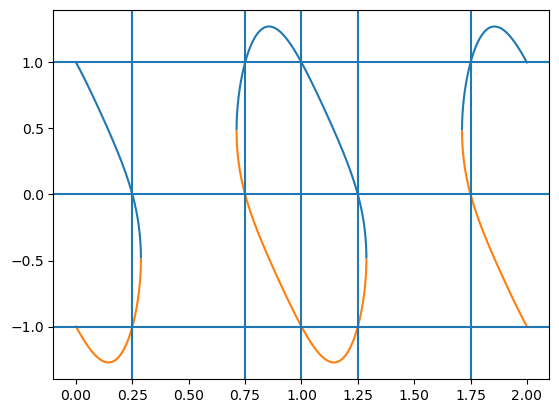

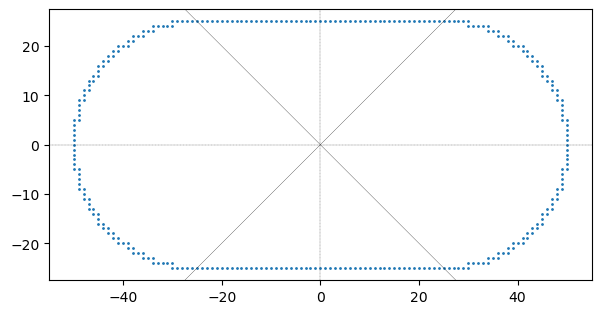

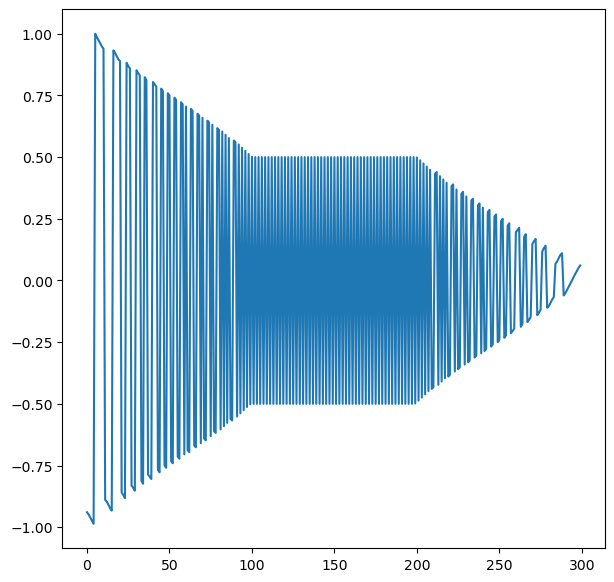

In [525]:
r = 25
L = 25
npoints = 100000
theta = np.linspace(0, 2*pi, npoints, endpoint = False)
boundary_points, normal_angles = generate_stadium(r,L, npoints = npoints)

points_that_I_plot = len(boundary_points[0])

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.scatter(boundary_points[0,:points_that_I_plot],boundary_points[1,:points_that_I_plot], s = 1)

ax.set_aspect('equal')
ax.set_xlim(1.1*(-r-L), 1.1*(r+L))
ax.set_ylim(-r*1.1,r*1.1)
ax.axhline(0, ls = '--', c = 'k', lw = 0.2)
ax.axvline(0, ls = '--', c = 'k', lw = 0.2)
ax.axline((0,0), slope = r/L, c = 'k', lw = 0.2)
ax.axline((0,0), slope = -r/L, c = 'k', lw = 0.2)

fig.show()

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.plot(normal_angles[:points_that_I_plot]/pi)#######This part!!!

fig.show()


In [526]:
def operators_stadium(parameters, plot_potential = False, plot_mass = False, plot_mag_field = False,return_shape = False):
    '''Returns operators Phi, H and P for a square 
    geometry boundary condition given by a magnetization that rotates parallel to the edge.'''
    
    Nx = parameters['Nx']     # Number of unit cells in x direction (should be odd)
    Ny = parameters['Ny']     # Number of unit cells in y direction (should be odd)
    kx = 0    # open system
    ky = 0    # open system
    
    #Generate Peierls phases
    #np.random.seed(0)
    if parameters['B1'] == 0:
        a_e = np.zeros((Ny,Nx))
        a_n = np.zeros((Ny,Nx))
    else:
        fluxes = make_fluxes(parameters, plot = plot_mag_field)
        a_e, a_n = vector_potential(parameters,fluxes)
        
    parameters['a_e'] = a_e
    parameters['a_n'] = a_n
    
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []    

    for i in range(Nx*Ny):
        y = i//Nx
        x = i%Nx
        
        #Peierls phases
        p_e = np.exp(1j*(a_e[y,x]))
        p_n = np.exp(1j*(a_n[y,x]))
        
        #Standard translations
        trs_e = np.exp(-(1j*kx*Nx)*((x+1)//Nx))
        trs_n = np.exp(-(1j*ky*Ny)*((y+1)//Ny))
        
        #Total phases
        phase_e = p_e*trs_e
        phase_n = p_n*trs_n
        
        row_Tx += [i]
        col_Tx += [((x+1)%Nx) + y*Nx]
        data_Tx += [phase_e*(1-(x//(Nx-1)))] ################## Open boundaries in x direction
        
        row_Ty += [i]
        col_Ty += [x + ((y+1)%Ny)*Nx]
        data_Ty += [phase_n*(1-(y//(Ny-1)))] ################## Open boundaries in y direction
        
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2

    potential_array = make_potential(parameters, plot = plot_potential).flatten()    
    pot = scipy.sparse.spdiags(potential_array, 0, Nx*Ny, Nx*Ny, format = "csc")
    V = scipy.sparse.kron(csc_matrix(sigma_0), pot, format = "csc")    
    
    mass_array = make_mass(parameters, plot = plot_mass).flatten()    
    mass = scipy.sparse.spdiags(mass_array, 0, Nx*Ny, Nx*Ny, format = "csc")
    M = scipy.sparse.kron(csc_matrix(sigma_z), mass, format = "csc")
    
    
    H_0 = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    H = H_0 + Phi.H@V@Phi + Phi.H@M@Phi

    
    # Unitary transformation on the edges. Let us build a rotation matrix that acts on a single site.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a (theta,phi) orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    def get_index(x,y,s):
        '''Returns the index of the orbital in x,y with spin s'''
        return int(Nx*Ny*s + Nx*y + x)

    edge_points, normal_angles = generate_stadium(r = Ny//2, L = Nx//2-Ny//2)
    edge_points = edge_points + np.array([[Nx//2]*(len(edge_points[1])),[Ny//2]*(len(edge_points[1]))])
    # the parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
    
    theta = parameters['theta']
    indices_to_delete = []
    
    for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):
        
        #rotate
        rotation = spin_rotation([point[0],point[1]], theta, point[2]) 
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
        
        #book index to delete
        indices_to_delete.append(get_index(point[0],point[1],1))

    #Now we also have to delete the outer part
    amount_out = 0
    def discriminant(x,y):
        L = Nx//2-Ny//2
        r = Ny//2
        if x<-L:
            return ((x+L)/r)**2+(y/r)**2
        elif x>L:
            return ((x-L)/r)**2+(y/r)**2
        else:
            return (y/r)**2
        
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    for x,y in zip(X.ravel(),Y.ravel()):
        if discriminant(x-Nx//2,y-Ny//2)>1 and  get_index(x,y,1) not in indices_to_delete:
            indices_to_delete.append(get_index(x,y,0))
            indices_to_delete.append(get_index(x,y,1))
            amount_out += 1

            
    # Transforming the sparse matrix into dense to delete spins (could I avoid this?)
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
   
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi

    if return_shape:
        inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)
        inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
        inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
        inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)
    
        return Phi, H, P, indices_to_delete, (inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:]), (inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out])
    else:
        return Phi, H, P, indices_to_delete

/tmp/ipykernel_11835/593593869.py:5: RuntimeWarning: invalid value encountered in sqrt
  cos_theta_plus = (np.cos(theta))**2   *    (-L/r*np.tan(theta)  + np.sqrt( np.ones(npoints) - ((np.tan(theta))**2*L**2/r**2-1)*(np.tan(theta))**2 ) )
/tmp/ipykernel_11835/593593869.py:6: RuntimeWarning: invalid value encountered in sqrt
  cos_theta_minus = (np.cos(theta))**2   *    (-L/r*np.tan(theta)  - np.sqrt( np.ones(npoints) - ((np.tan(theta))**2*L**2/r**2-1)*(np.tan(theta))**2 ) )
/tmp/ipykernel_11835/593593869.py:27: RuntimeWarning: divide by zero encountered in divide
  x = np.where(np.abs(theta-pi/2)<=np.arctan(L/r),r/np.tan(theta),x)
/tmp/ipykernel_11835/593593869.py:29: RuntimeWarning: divide by zero encountered in divide
  x = np.where(np.abs(theta-3*pi/2)<=np.arctan(L/r),-r/np.tan(theta),x)


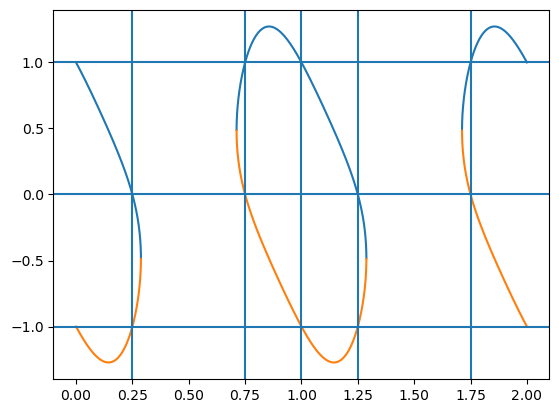

In [606]:
#Testing

Nx = 45
Ny = 22
def get_index(x,y,s):
    '''Returns the index of the orbital in x,y with spin s'''
    return int(Nx*Ny*s + Nx*y + x)

edge_points, normal_angles = generate_stadium(r = Ny//2-1, L = Nx//2-Ny//2-1,npoints =1000000)
edge_points = edge_points + np.array([[Nx//2]*(len(edge_points[1])),[Ny//2]*(len(edge_points[1]))])

indices_to_delete = []

#Delete edges
for point in zip(edge_points[0], edge_points[1]):
    #book index to delete
    indices_to_delete.append(get_index(point[0],point[1],1))


#Delete outside
amount_out = 0
def discriminant(x,y):
    L = Nx//2-Ny//2-1
    r = Ny//2-1
    if x<-L:
        return ((x+L)/r)**2+(y/r)**2
    elif x>L:
        return ((x-L)/r)**2+(y/r)**2
    else:
        return (y/r)**2
X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
for x,y in zip(X.ravel(),Y.ravel()):
    if discriminant(x-Nx//2,y-Ny//2)>=1 and  get_index(x,y,1) not in indices_to_delete:
        indices_to_delete.append(get_index(x,y,0))
        indices_to_delete.append(get_index(x,y,1))
        amount_out += 1

In [607]:
inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)

inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)

/tmp/ipykernel_11835/3942523850.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


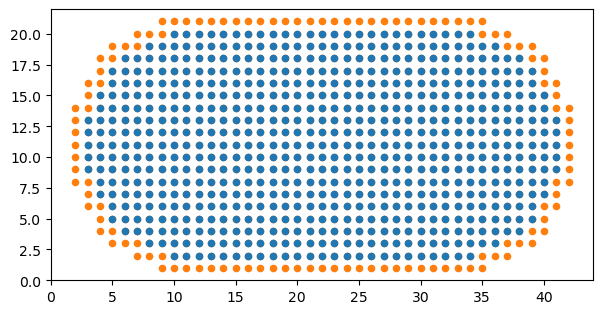

In [608]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.scatter(inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:], s = 20)
ax.scatter(inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out], s = 20,zorder=-1)

ax.set_aspect('equal')
fig.show()

# Let us try to remove the inner corner points

In [88]:
def generate_ellipse(r1,r2,npoints=1000):
    'Generates the set of points in the grid closest to an elipse with radii r1 and r2 and the angle of the normal vector.'
    theta = np.linspace(0, 2*np.pi, npoints)
    x = r1*np.cos(theta)
    y = r2*np.sin(theta)
    angles = np.where(np.abs(theta-pi)<=pi/2, np.arctan((r1/r2)*np.tan(theta))+pi, np.arctan((r1/r2)*np.tan(theta)))
    z = np.exp(1j*angles)

    boundary_points, indices = np.unique(np.round(np.stack((x, y))), axis = 1, return_inverse=True)

    # Here I want to remove the points that are inside, what do I do with the normal? I guess I just ignore them, why not
    polar_angle = np.arctan2(boundary_points[1],boundary_points[0])
    boundary_points = boundary_points[:,np.argsort(polar_angle)]
    second_displacements = np.roll(boundary_points,1,axis = 1)+np.roll(boundary_points,-1,axis = 1)-2*boundary_points #This is like a discrete second derivative.
    
    # Calculate the sum of elements in z that correspond to the same value in mask
    sums_real = np.bincount(indices, weights=z.real)
    sums_imag = np.bincount(indices, weights=z.imag)
    
    # Calculate the count of elements in b that correspond to the same value in mask
    counts = np.bincount(indices)
    
    # Calculate the average of elements in b that correspond to the same value in mask
    normal_angles = np.angle((sums_real + 1j*sums_imag)/counts)
    normal_angles = normal_angles[np.argsort(polar_angle)]

    in_or_out = second_displacements[0]*np.cos(normal_angles) + second_displacements[1]*np.sin(normal_angles)

    boundary_points = boundary_points[:,np.argwhere(in_or_out<=0.1).flatten()]
    normal_angles = normal_angles[np.argwhere(in_or_out<=0.1).flatten()]
    
    return boundary_points, normal_angles

/tmp/ipykernel_17408/3713392127.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_17408/3713392127.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


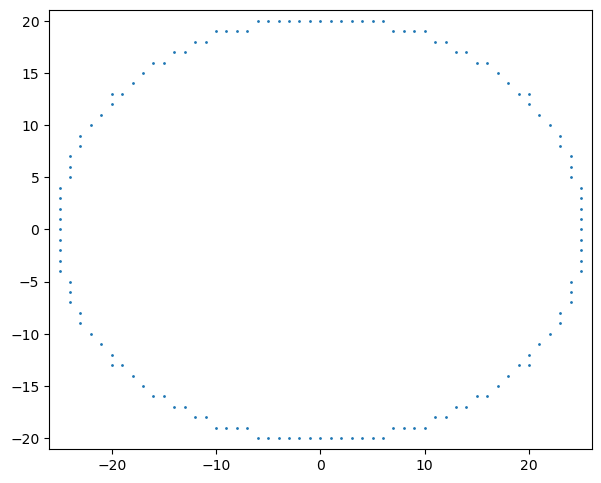

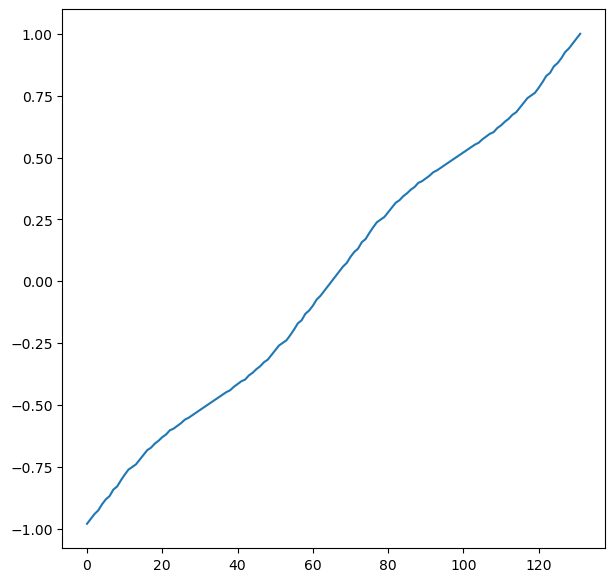

In [89]:
R1 = 25
R2 = R1*57/71
boundary_points, normal_angles = generate_ellipse(R1,R2, npoints = 1000000)
NNpoints = len(boundary_points[0])
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.scatter(boundary_points[0,:NNpoints+1],boundary_points[1,:NNpoints+1], s = 1)
ax.set_xlim(-R1-1,R1+1)
ax.set_ylim(-R2-1,R2+1)
ax.set_aspect('equal')
fig.show()

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.plot(normal_angles[:NNpoints]/pi)
fig.show()